In his book, [_Neural Networks - A Comprehensive Foundation_](https://www.amazon.com/Neural-Networks-Comprehensive-Simon-Haykin/dp/0023527617/ref=sr_1_1?ie=UTF8&qid=1468746091&sr=8-1&keywords=neural+networks+comprehensive+foundation), Simon Haykin has an entire section (3.10) dedicated to how perceptrons and Bayesian classifiers are closely related when operating in a Gaussian environment. However, it is not until the end of the section that Haykin mentions that the relation is only limited to linearity. What is interesting about this is that a Perceptron can produce the same classification "model" as a Bayesian classifier, provided that the underlying data is drawn from a Gaussian distribution. This post is an experimental verification of that.
<!---TEASER_END--->

All linear classifiers, either implicitly or explicitly take the following form:

$$ y = \sum_{i=1}^{m} w_{i}x_{i} + b = \mathbf{w^{T}x} + b $$

where $\mathbf{w}$ is the weight vector (or coefficients) of the classifier, $b$ is the bias (or intercept), $\mathbf{x}$ is the input vector and $y$ is the scalar output. The sign of $y$ denotes the predicted class for a given input $x$.

A perceptron can easily be characterized by such an expression, but a Bayesian classifier has no concept of weights and biases or slopes and intercepts. It makes decisions by computing the log-likelihood ratio $log\Lambda(\mathbf{x})$ of the input vector $\mathbf{x}$ and compares it to a threshold $\xi$. The comparison essentially decides the predicted class for input $\mathbf{x}$.

After some amount of straightforward but somewhat lengthy algebra, Haykin is able to show that the _slope and intercept_ form and the _log-likelohood and threshold_ form are related in the simple manner. Suppose we define the following equations,

$$ y = log\Lambda(\mathbf{x}) $$

$$ \mathbf{x} = \mathbf{C}^{-1}(\mathbf{\mu_{1}} - \mathbf{\mu_{2}}) $$

$$ b = \frac{1}{2}(\mathbf{\mu_{2}^{T}}\mathbf{C}^{-1}\mathbf{\mu_{2}} - \mathbf{\mu_{1}^{T}}\mathbf{C}^{-1}\mathbf{\mu_{1}}) $$

where $\mathbf{C}$ is the covariance matrix of the dataset $X = [\mathbf{x_{1}}, \mathbf{x_{2}}, ... \mathbf{x_{n}}]$, and $\mathbf{\mu_{i}}$ is the mean of the input vectors belonging to the $i$th class, for $i \in [1, 2]$, then the decision function can be rewritten as

$$ y = \mathbf{w^{T}x} + b $$

---------------------

To verify this, let's make up a classification problem and train a Gaussian Bayes classifier on it.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
%matplotlib inline

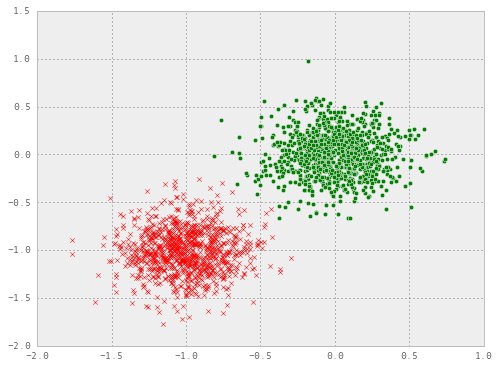

In [4]:
# make some data
x1 = np.random.multivariate_normal([0, 0], [[0.05, 0], [0, 0.05]], size=(1000,))
x2 = np.random.multivariate_normal([-1, -1], [[0.05, 0], [0, 0.05]], size=(1000,))
plt.figure(figsize=(8, 6))
plt.scatter(x1[:, 0], x1[:, 1], marker="o", c="g")
plt.scatter(x2[:, 0], x2[:, 1], marker="x", c="r")

In [5]:
# adding labels and normalizing data
x1 = np.c_[x1, np.ones((1000, 1))]
x2 = np.c_[x2, np.zeros((1000, 1))]
X = np.r_[x1, x2]
X = StandardScaler().fit_transform(X)
np.random.shuffle(X)
y = X[:, -1]
X = X[:, :-1]
y[y != 1] = 0

In [6]:
# define a function to help us draw a decision boundary
def draw_decision_boundary(clf, X, y):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.4)
    plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.8)

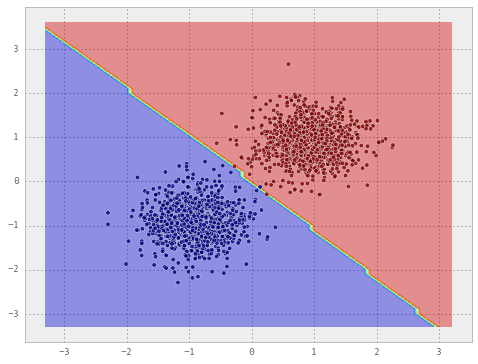

In [7]:
# train a Gaussian Naive Bayes classifier on the dataset
clf = GaussianNB()
clf.fit(X, y)
draw_decision_boundary(clf, X, y)

### Estimation of the weights and the bias

With a little bit of [numpy.ndarray](http://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.html) hacking, we can produce $\mathbf{w}$ and $b$ in the equations above from the covariance matrix of $\mathbf{X}$ and its classwise means.

In [8]:
C = np.cov(X.T)
mu1 = X[y == 1, :].mean(0)
mu2 = X[y == 0, :].mean(0)

In [11]:
c_inverse = np.linalg.inv(C)
weights = np.dot(c_inverse, mu1 - mu2).reshape(-1, 1)
intercept = np.dot(np.dot(mu2.reshape(1, -1), c_inverse).ravel(), mu2) - \
            np.dot(np.dot(mu1.reshape(1, -1), c_inverse).ravel(), mu1)

Now that we have the estimated weights and the intercept, let's create a Perceptron classifier from these and see its performance.

In [12]:
from sklearn.linear_model import Perceptron

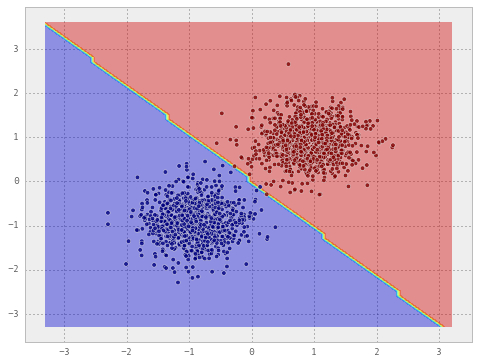

In [21]:
clf = Perceptron()
clf.fit(X, y) # Note that this is only necessary to make fool sklearn - it won't draw the decision surface otherwise
clf.coef_ = weights.T
clf.intercept_ = intercept
draw_decision_boundary(clf, X, y)

Observe that both the classifiers draw almost the same decision line.

----------

I think it needs to be emphasized that the relationship between a Bayesian classifier and a perceptron ends at linearity. They are not equivalent or even complementary beyond the assumption of linearity and a normal distribution. A Bayesian classifier is parametric, a perceptron is not. A Bayesian classifier is generative, a perceptron is discriminative. So nothing practical may come of this excercise deriving one from the other - it just goes to show that a Bayesian classifier can be expressed as a dot product.